In [3]:
import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules
import random
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

In [4]:
data_path = "preprocessed_dataset.csv"
df = pd.read_csv(data_path)

In [6]:
df['Big_city'] = df['city_pop'].apply(lambda x: True if x > 20000 else False)

transaction_data = (
    df.groupby(['line_number', 'Big_city'])['category']
    .apply(list)
    .reset_index()
)

def add_random_categories(transaction, transaction_data, max_categories=4):
    all_categories = transaction_data['category'].explode().unique()
    remaining_categories = list(set(all_categories) - set(transaction))
    
    num_categories_to_add = min(max_categories - len(transaction), len(remaining_categories))
    categories_to_add = random.sample(remaining_categories, num_categories_to_add)
    transaction.extend(categories_to_add)
    
    return transaction

transaction_data['category'] = transaction_data['category'].apply(
    lambda x: add_random_categories(x, transaction_data, max_categories=4)
)

one_hot = pd.get_dummies(transaction_data.explode('category'), columns=['category'], prefix='', prefix_sep='')
transaction_df = (
    one_hot.groupby('line_number')
    .max()
    .astype(int)
)

transaction_df.to_csv("transaction_data.csv", index=False)

for col in transaction_df.columns:
    if not set(transaction_df[col].unique()).issubset({0, 1}):
        print(f"Column {col} contains non-binary values: {transaction_df[col].unique()}")

In [18]:
frequent_itemsets = apriori(transaction_df, min_support=0.05, use_colnames=True, max_len=5,)
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.6, num_itemsets=len(df))

print(frequent_itemsets)
print(f"rules: {rules}")
print(rules.head())

def run_apriori_on_subset(transaction_data, city_value, city_column):
    subset_data = transaction_data[transaction_data[city_column] == city_value]
    print(f"Subset data shape: {subset_data.shape}")
    frequent_itemsets_subset = apriori(subset_data, min_support=0.005, use_colnames=True)
    rules_subset = association_rules(frequent_itemsets_subset, metric="confidence", min_threshold=0.1, num_itemsets=len(subset_data))

    return frequent_itemsets_subset, rules_subset

frequent_itemsets_big, rules_big = run_apriori_on_subset(transaction_df, True, 'Big_city')
frequent_itemsets_small, rules_small = run_apriori_on_subset(transaction_df, False, 'Big_city')

print("Big City Rules:")
print(rules_big)

print("Small City Rules:")
print(rules_small)

c:\Users\jarne\OneDrive - UC Leuven-Limburg\BAC 3\Semester 1\Data Mining\.venv\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
c:\Users\jarne\OneDrive - UC Leuven-Limburg\BAC 3\Semester 1\Data Mining\.venv\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


      support                       itemsets
0    0.254403                     (Big_city)
1    0.279071                (entertainment)
2    0.286657                  (food_dining)
3    0.311853                (gas_transport)
4    0.252952                  (grocery_net)
..        ...                            ...
115  0.073082  (shopping_pos, personal_care)
116  0.060088        (travel, personal_care)
117  0.071367   (shopping_net, shopping_pos)
118  0.061935         (shopping_net, travel)
119  0.061869         (shopping_pos, travel)

[120 rows x 2 columns]
rules: Empty DataFrame
Columns: [antecedents, consequents, antecedent support, consequent support, support, confidence, lift, representativity, leverage, conviction, zhangs_metric, jaccard, certainty, kulczynski]
Index: []
Empty DataFrame
Columns: [antecedents, consequents, antecedent support, consequent support, support, confidence, lift, representativity, leverage, conviction, zhangs_metric, jaccard, certainty, kulczynski]
Index: 

c:\Users\jarne\OneDrive - UC Leuven-Limburg\BAC 3\Semester 1\Data Mining\.venv\lib\site-packages\mlxtend\frequent_patterns\association_rules.py:182: RuntimeWarning: invalid value encountered in divide
  cert_metric = np.where(certainty_denom == 0, 0, certainty_num / certainty_denom)
c:\Users\jarne\OneDrive - UC Leuven-Limburg\BAC 3\Semester 1\Data Mining\.venv\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


Big City Rules:
                           antecedents               consequents  \
0                      (entertainment)                (Big_city)   
1                           (Big_city)           (entertainment)   
2                           (Big_city)             (food_dining)   
3                        (food_dining)                (Big_city)   
4                      (gas_transport)                (Big_city)   
...                                ...                       ...   
4297  (shopping_net, Big_city, travel)            (shopping_pos)   
4298  (shopping_pos, Big_city, travel)            (shopping_net)   
4299      (shopping_net, shopping_pos)        (Big_city, travel)   
4300            (shopping_net, travel)  (shopping_pos, Big_city)   
4301            (shopping_pos, travel)  (shopping_net, Big_city)   

      antecedent support  consequent support   support  confidence      lift  \
0               0.278973            1.000000  0.278973    1.000000  1.000000   
1      

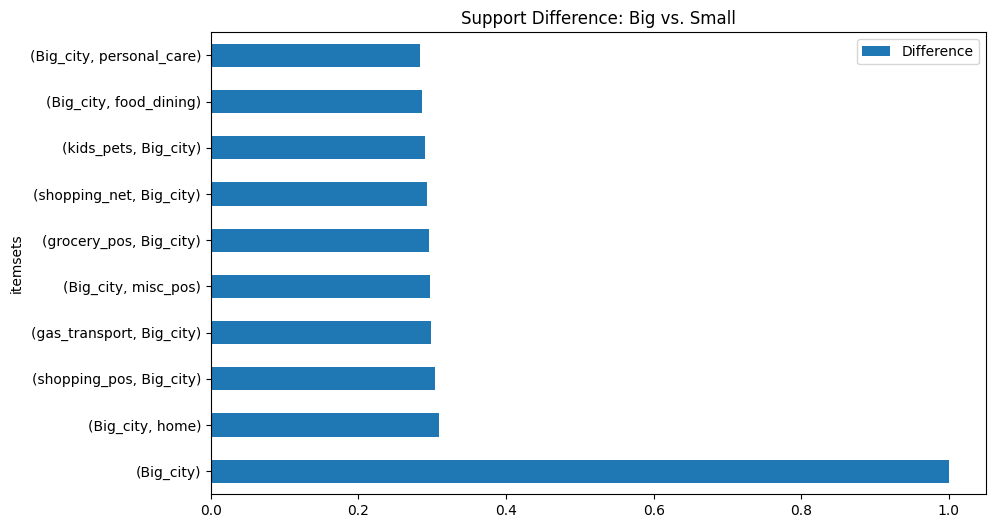

In [19]:
def plot_support_difference(frequent_itemsets_1, frequent_itemsets_2, label1, label2):
    merged = pd.merge(
        frequent_itemsets_1.rename(columns={'support': f'support_{label1}'}),
        frequent_itemsets_2.rename(columns={'support': f'support_{label2}'}),
        on='itemsets', how='outer'
    ).fillna(0)
    merged['Difference'] = merged[f'support_{label1}'] - merged[f'support_{label2}']
    merged = merged.sort_values('Difference', key=abs, ascending=False).head(10)
    merged.set_index('itemsets')[['Difference']].plot(kind='barh', figsize=(10, 6))
    plt.title(f'Support Difference: {label1} vs. {label2}')
    plt.show()

if frequent_itemsets_big is not None and frequent_itemsets_small is not None:
    plot_support_difference(frequent_itemsets_big, frequent_itemsets_small, 'Big', 'Small')

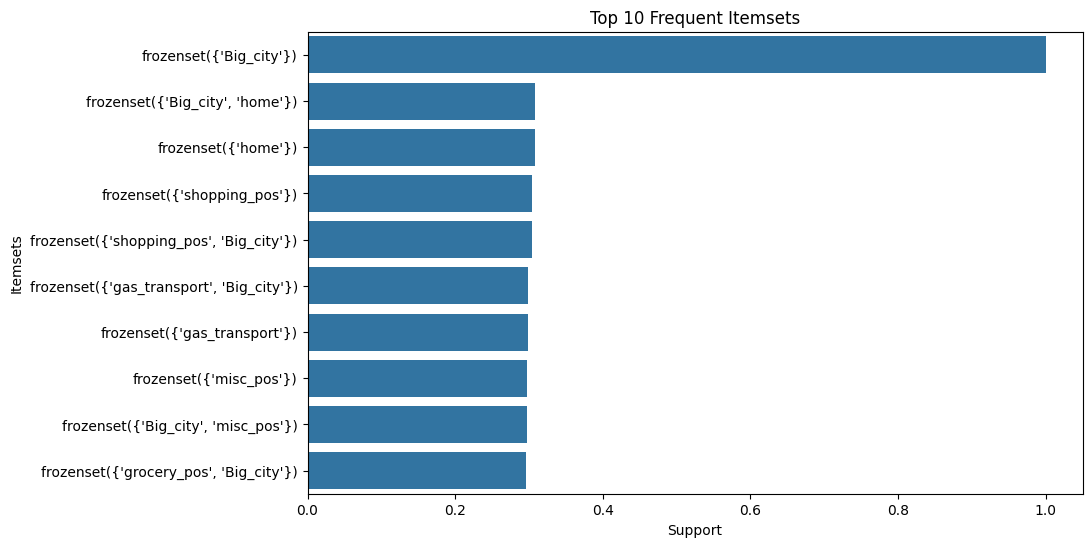

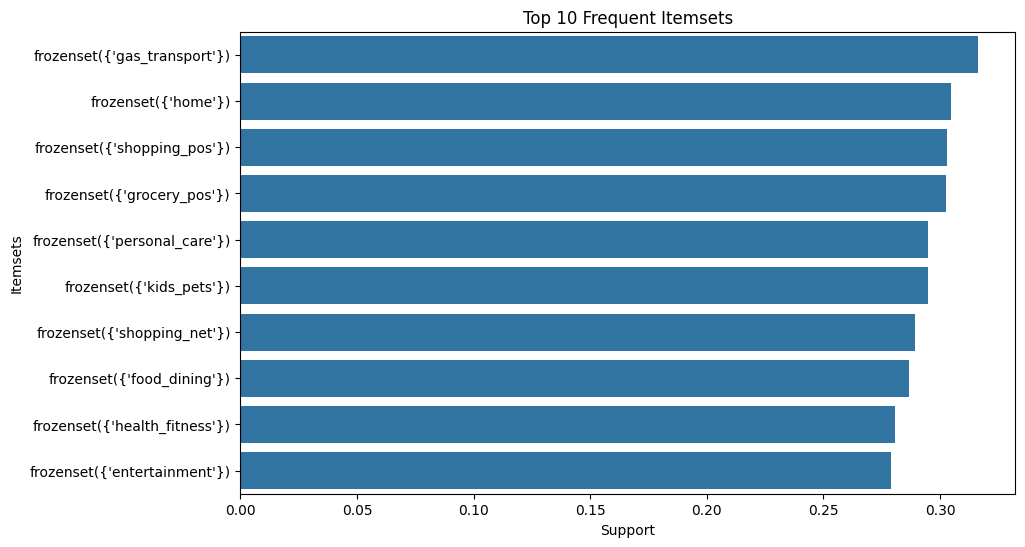

In [14]:
def plot_frequent_itemsets(frequent_itemsets):
    plt.figure(figsize=(10, 6))
    sns.barplot(x='support', y='itemsets', data=frequent_itemsets.sort_values(by='support', ascending=False).head(10))
    plt.title('Top 10 Frequent Itemsets')
    plt.xlabel('Support')
    plt.ylabel('Itemsets')
    plt.show()

plot_frequent_itemsets(frequent_itemsets_big)
plot_frequent_itemsets(frequent_itemsets_small)


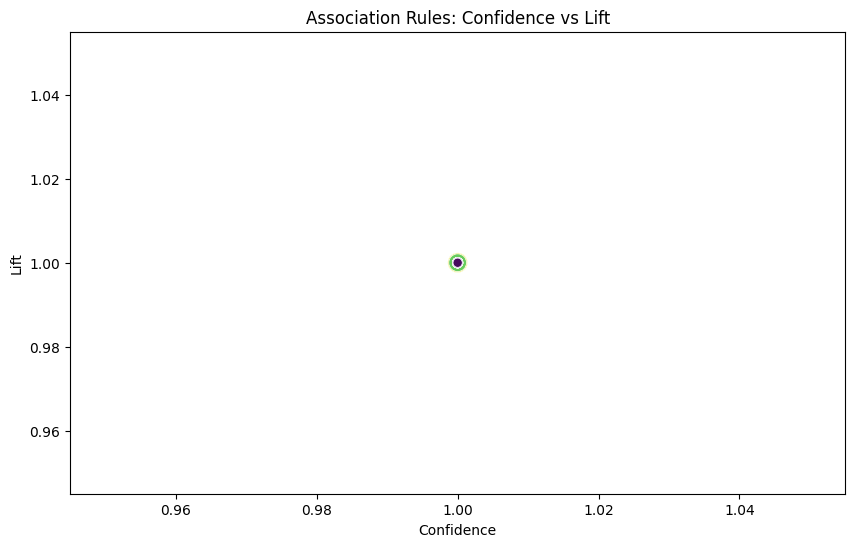

C:\Users\jarne\AppData\Local\Temp\ipykernel_15692\3983855504.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x='confidence', y='lift', data=rules, hue='support', palette='viridis', size='support', sizes=(40, 200), legend=False)


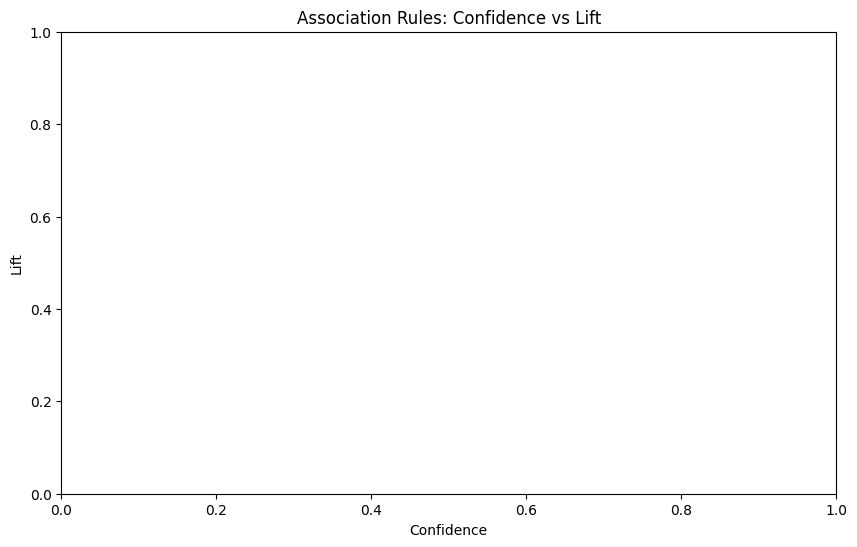

In [10]:
def plot_association_rules(rules):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='confidence', y='lift', data=rules, hue='support', palette='viridis', size='support', sizes=(40, 200), legend=False)
    plt.title('Association Rules: Confidence vs Lift')
    plt.xlabel('Confidence')
    plt.ylabel('Lift')
    plt.show()

plot_association_rules(rules_big)
plot_association_rules(rules_small)

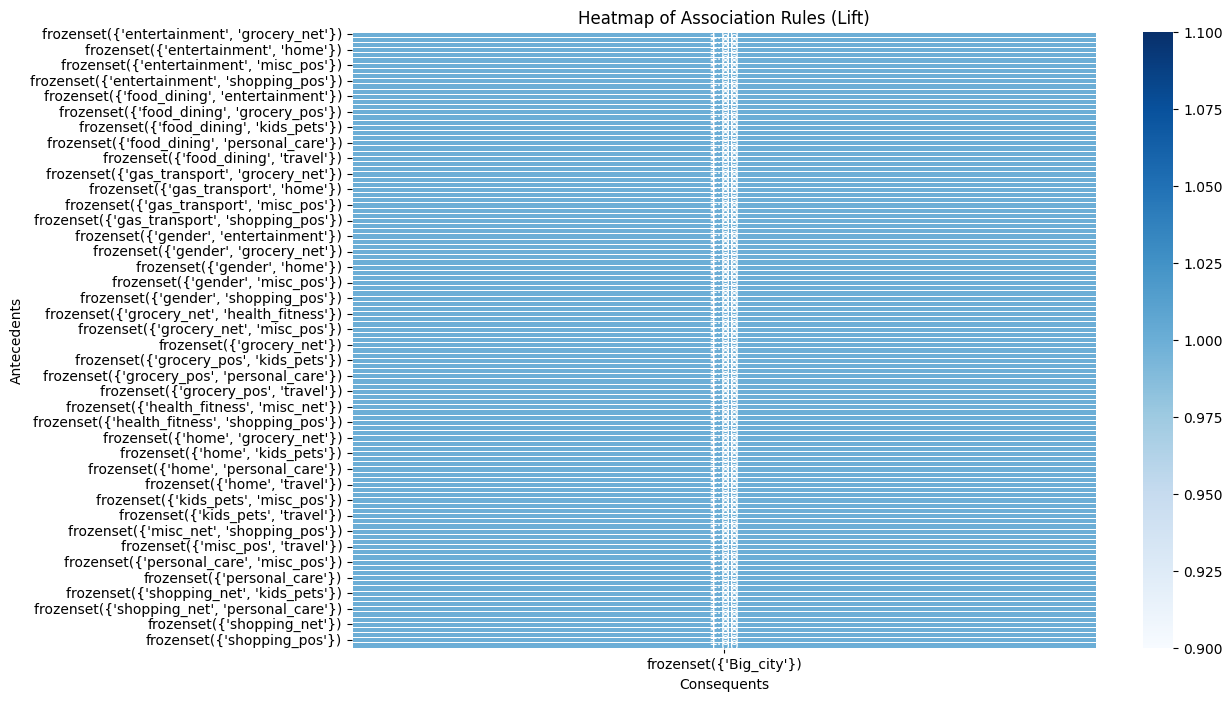

ValueError: zero-size array to reduction operation fmin which has no identity

<Figure size 1200x800 with 0 Axes>

In [43]:
def plot_heatmap_of_rules(rules):
    antecedents = rules['antecedents'].apply(lambda x: str(x))
    consequents = rules['consequents'].apply(lambda x: str(x))
    heatmap_data = pd.crosstab(antecedents, consequents, values=rules['lift'], aggfunc='mean', dropna=True)
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(heatmap_data, cmap='Blues', annot=True, fmt=".2f", linewidths=0.5)
    plt.title('Heatmap of Association Rules (Lift)')
    plt.xlabel('Consequents')
    plt.ylabel('Antecedents')
    plt.show()

plot_heatmap_of_rules(rules_big)
plot_heatmap_of_rules(rules_small)

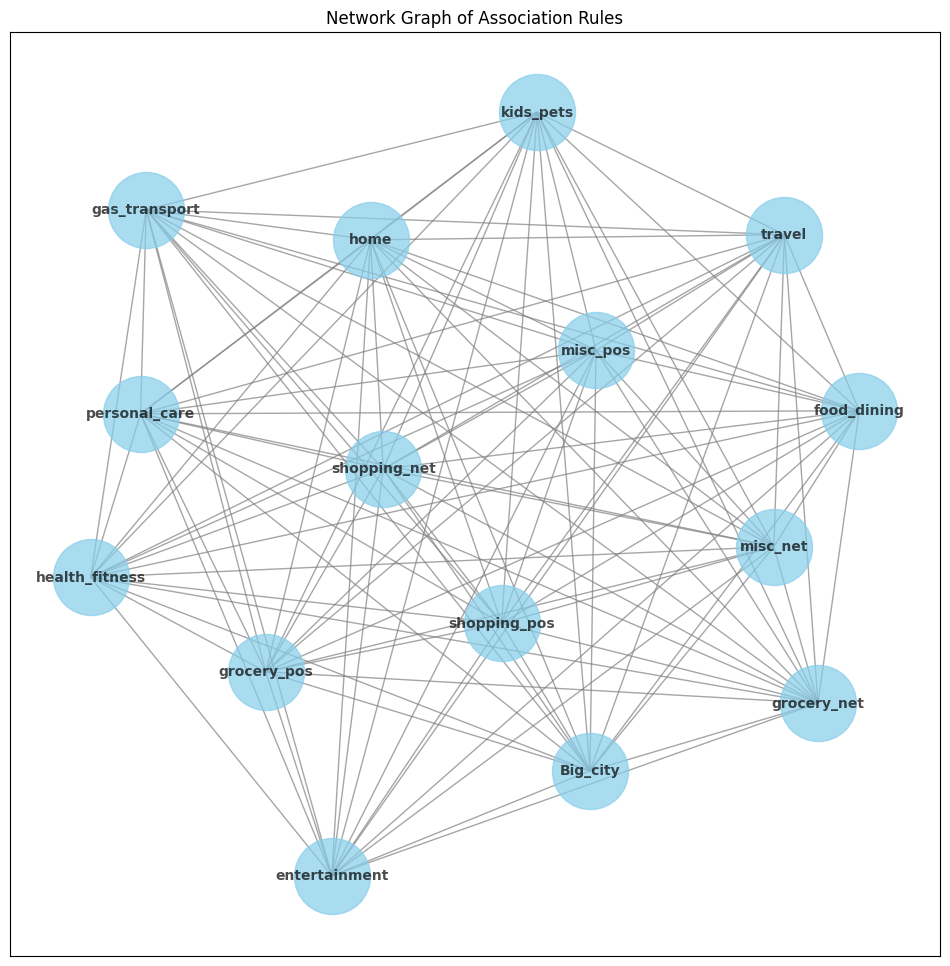

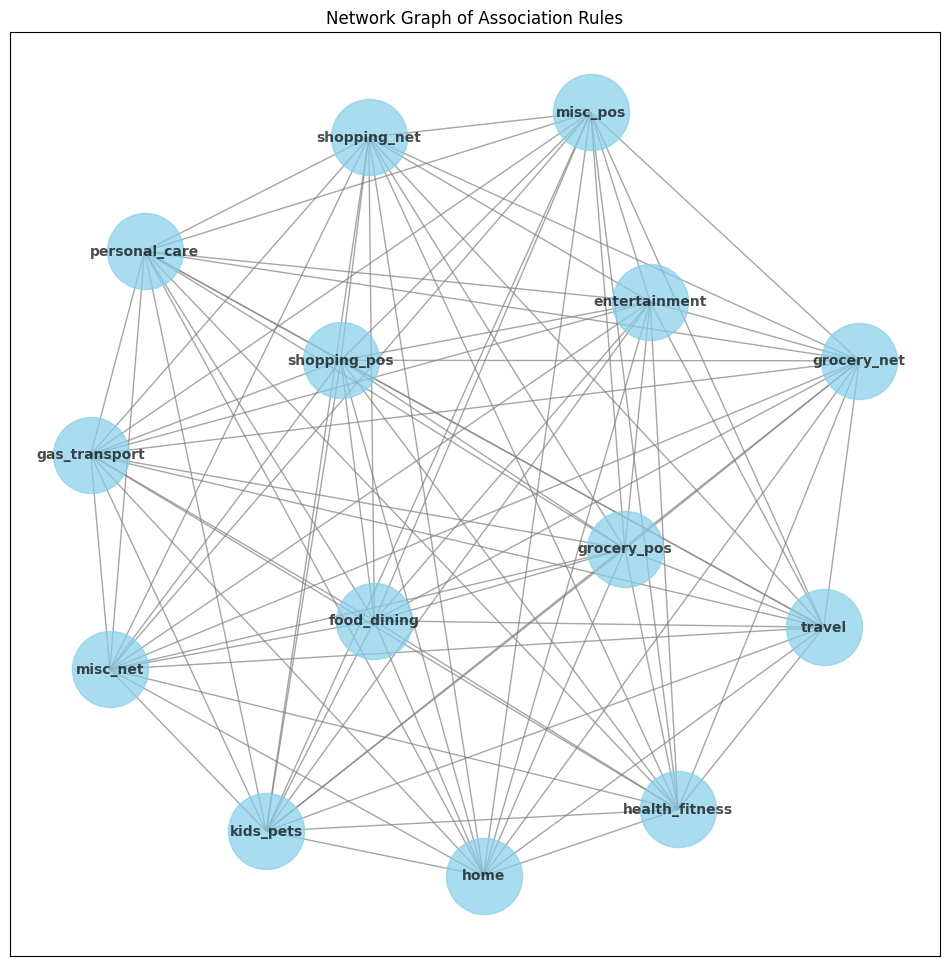

In [20]:
def plot_network_of_rules(rules):
    G = nx.Graph()
    for _, row in rules.iterrows():
        for antecedent in row['antecedents']:
            for consequent in row['consequents']:
                G.add_edge(str(antecedent), str(consequent), weight=row['lift'])

    plt.figure(figsize=(12, 12))
    pos = nx.spring_layout(G, k=0.15, iterations=20)
    nx.draw_networkx(G, pos, with_labels=True, node_size=3000, node_color='skyblue', font_size=10, font_weight='bold', edge_color='gray', width=1, alpha=0.7)
    plt.title('Network Graph of Association Rules')
    plt.show()

plot_network_of_rules(rules_big)
plot_network_of_rules(rules_small)

In [46]:
def display_top_rules(rules, top_n=10):
    top_rules = rules.sort_values(by='lift', ascending=False).head(top_n)
    print(top_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']])

display_top_rules(rules_big)
display_top_rules(rules_small)

        antecedents consequents   support  confidence  lift
0          (gender)  (Big_city)  0.491833         1.0   1.0
1   (entertainment)  (Big_city)  0.283122         1.0   1.0
2     (food_dining)  (Big_city)  0.286492         1.0   1.0
3   (gas_transport)  (Big_city)  0.292196         1.0   1.0
4     (grocery_net)  (Big_city)  0.262121         1.0   1.0
5     (grocery_pos)  (Big_city)  0.305159         1.0   1.0
6  (health_fitness)  (Big_city)  0.277418         1.0   1.0
7            (home)  (Big_city)  0.301270         1.0   1.0
8       (kids_pets)  (Big_city)  0.301789         1.0   1.0
9        (misc_net)  (Big_city)  0.261862         1.0   1.0
Empty DataFrame
Columns: [antecedents, consequents, support, confidence, lift]
Index: []


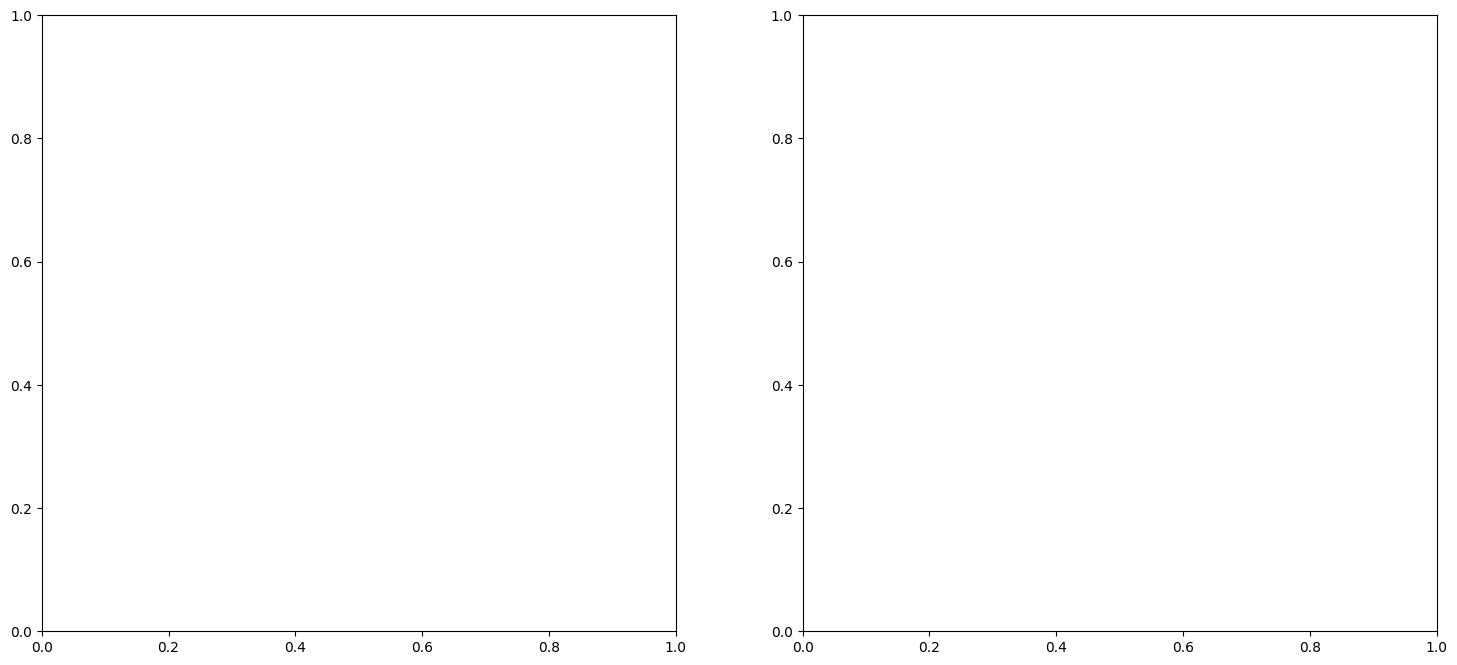

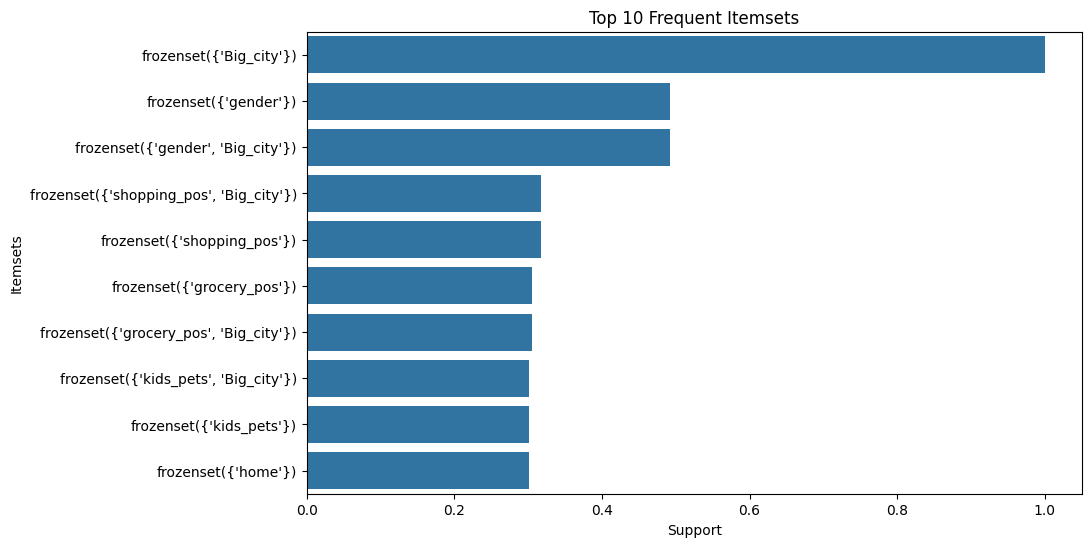

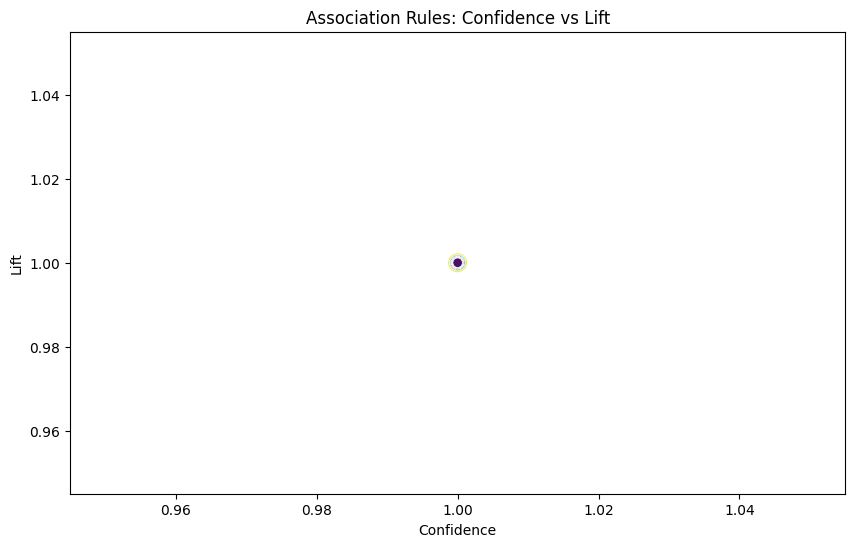

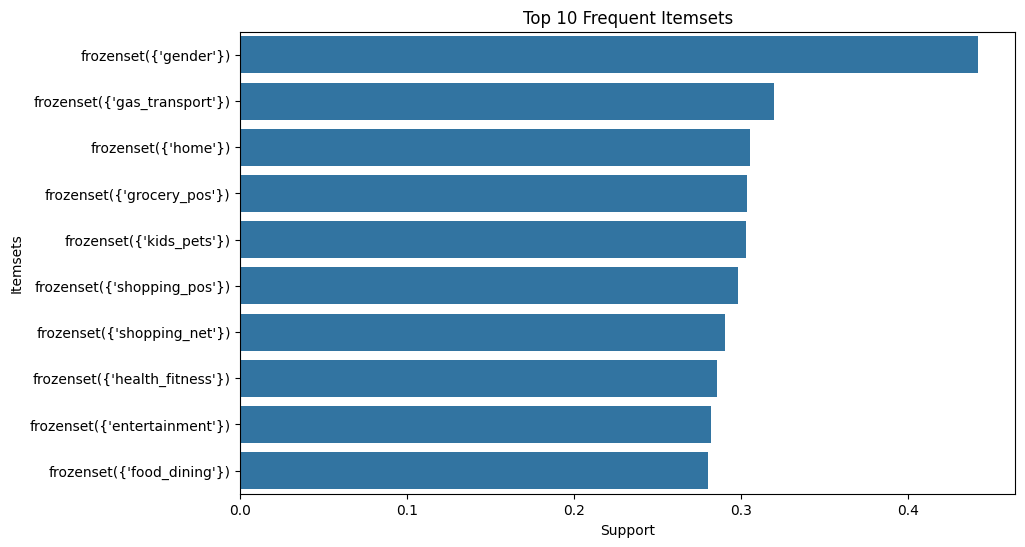

C:\Users\jarne\AppData\Local\Temp\ipykernel_11004\4138334398.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x='confidence', y='lift', data=rules, hue='support', palette='viridis', size='support', sizes=(40, 200), legend=False)


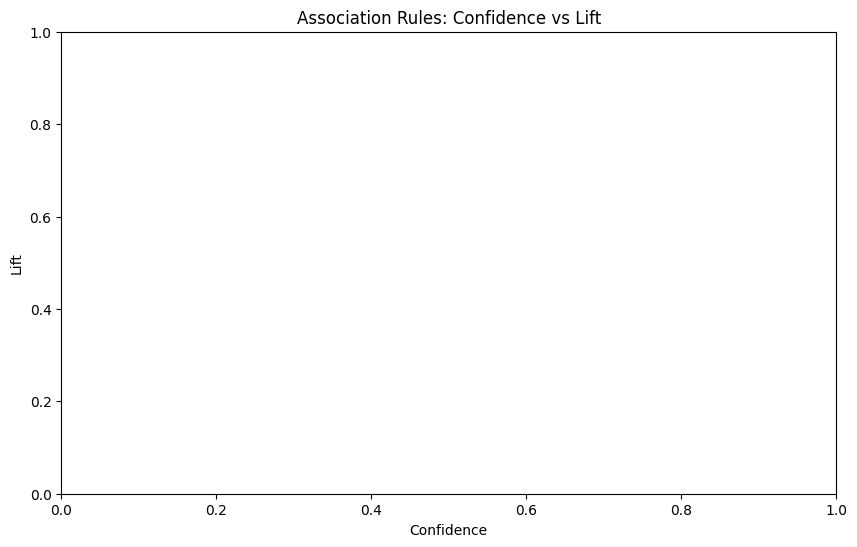

In [47]:
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

plot_frequent_itemsets(frequent_itemsets_big)
plot_association_rules(rules_big)

plot_frequent_itemsets(frequent_itemsets_small)
plot_association_rules(rules_small)